# Annealed importance sampling to generate sample from 1D GZ with Euler-Maruyama at $\beta$ 

Saved data at iteration 0, total violation is 0
Saved data at iteration 1, total violation is 0
Saved data at iteration 2, total violation is 0
Saved data at iteration 3, total violation is 0
Saved data at iteration 4, total violation is 0
Saved data at iteration 5, total violation is 0
Saved data at iteration 6, total violation is 0
Saved data at iteration 7, total violation is 0
Saved data at iteration 8, total violation is 0
Saved data at iteration 9, total violation is 0
Saved data at iteration 10, total violation is 0
Saved data at iteration 11, total violation is 0
Saved data at iteration 12, total violation is 0
Saved data at iteration 13, total violation is 0
Saved data at iteration 14, total violation is 0
Saved data at iteration 15, total violation is 0
Saved data at iteration 16, total violation is 0
Saved data at iteration 17, total violation is 0
Saved data at iteration 18, total violation is 0
Saved data at iteration 19, total violation is 0
Saved data at iteration 20, to

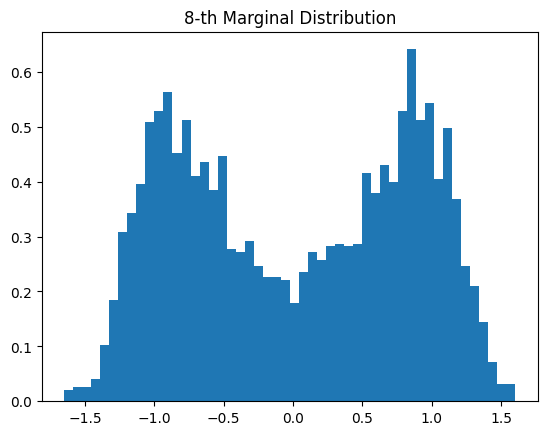

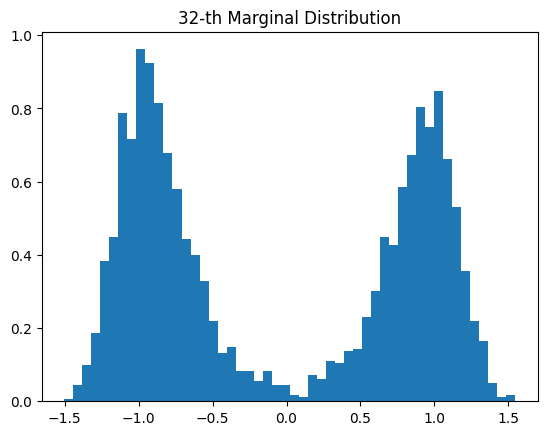

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Given constants
d = 64
h = 1 / (d + 1)
λ = 0.01
β0 = 3  # High temperature warm-up 

β = 6  # Low temperature
N_AIS = 100 
dβ = (β - β0) / N_AIS
V_grid = np.arange(β0,β+dβ,dβ) / β  # grid points used to compute effective potential

T = 1
scale = 120 # 120 for d = 64
dt = 0.0005 * scale / β0
N = int(T*scale/dt)  # Interested in T = 1
dt = T*scale/N  # Correct for small deviation

l_MALA = True  # MALA option
l_AIS = True  # AIS option
N_AIS_MALA = 1  # Number of MALA steps per AIS step

BATCH_SIZE = 100  # Set your desired batch size

stretch = 10

data_path = f"./Saved_Data/1D_GZ_data_d_{d}.npz"

# Hyperparameters
hyperparameters = {
    "d": d,
    "h": h,
    "λ": λ,
    "β": β,
    "dt": dt,
    "N": N,
    "BATCH_SIZE": BATCH_SIZE
}

# # Create directory if it doesn't exist
# if not os.path.exists("./Saved_Data"):
#     os.makedirs("./Saved_Data")

if os.path.exists(data_path):
    os.remove(data_path)

# # Load existing data or initialize
# if os.path.exists(data_path):
#     with np.load(data_path) as data:
#         all_samples = data['samples']
# else:

all_samples_β0 = np.empty((0, d + 2))
if l_AIS:
    all_samples = np.empty((0, d + 2))

def V(U, AIS_step=0):
    # potential energy V
    if np.size(U.shape) == 1:
        U = U[np.newaxis,:]
    dim0 = U.shape[0]
    U = np.concatenate((np.zeros((dim0,1)), U, np.zeros((dim0,1))), axis=1)
    return V_grid[AIS_step] * β / d * ( λ/h**2/2 * np.sum((U - np.roll(U, 1, axis = 1))**2, axis = 1) + np.sum(((1 - U**2)**2)[:, 1:-1], axis = 1) /4/λ )
        
def V_grad(U, AIS_step=0):
    # Gradient of the potential energy V
    if np.size(U.shape) == 1:
        U = U[np.newaxis,:]
    dim0 = U.shape[0]
    U = np.concatenate((np.zeros((dim0,1)), U, np.zeros((dim0,1))), axis=1)
    return V_grid[AIS_step] * β / d * ( λ/h**2 * (2*U - np.roll(U, 1, axis = 1) - np.roll(U, -1, axis = 1)) - U * (1 - U**2) /λ ) [:, 1:-1]
    
def Langevin_step(U,V,V_grad,l_MALA=True):

    if np.size(U.shape) == 1:
        U = U[np.newaxis,:]
    dim0 = U.shape[0]
    
    dW = np.sqrt(dt) * np.random.randn(dim0, d)
    
    U_tmp = U.copy()
    U_tmp += (-V_grad(U_tmp) * dt + np.sqrt(2) * dW)

    count = np.sum(U_tmp > 2.5) + np.sum(U_tmp <-2.5)
    U_tmp[U_tmp > 2.5] = 2.5
    U_tmp[U_tmp < -2.5] = -2.5

    if l_MALA:
        log_acceptance_ratio = np.minimum(0.0, - (V(U_tmp) - V(U)) \
                                      - 1/4/dt * (np.sum(((U - U_tmp + dt * V_grad(U_tmp)))**2,axis=1) \
                                                      - np.sum(((U_tmp - U + dt * V_grad(U)))**2,axis=1)))
        # Accept or reject
        accept = np.log(np.random.uniform(size=U.shape[0])) < log_acceptance_ratio
        
        # print(np.sum(accept))
    
        return np.where(accept[:, None], U_tmp, U), count
    else:
        return U_tmp, count

def Snooker(U,V_AIS_tmp,i,candid):

    u = np.random.uniform(0, 1)
    z = (u * np.sqrt(stretch) + (1 / np.sqrt(stretch)) * (1 - u))**2

    rand_ind = np.random.choice(candid)
    U_tmp = (1 - z) * U[rand_ind,:] + z * U[i,:]

    log_acceptance_ratio = np.minimum(0.0, (d-1) * np.log(z) - (V_AIS_tmp(U_tmp) - V_AIS_tmp(U[i,:]))) 
    # Accept or reject
    accept = np.log(np.random.uniform(size=1)) < log_acceptance_ratio

    if accept:
        U[i,:] = U_tmp
    
    return U

def BD(U,i,candid):
    rate = V(U,-1) - V(U,0)
    rate_i = rate[i] - np.mean(rate)

    if rate_i > 0:
        if np.log(np.random.uniform(size=1)) > - rate_i / N_AIS:
            rand_ind = np.random.choice(candid)
            U[i,:] = U[rand_ind,:]
    else:
        if np.log(np.random.uniform(size=1)) > rate_i / N_AIS:
            rand_ind = np.random.choice(candid)
            U[rand_ind,:] = U[i,:]
            
    return U

count = 0

for iteration in range(30):
    
    # U = np.zeros((BATCH_SIZE, d))  # Initialize at each iteration
    U = np.ones((BATCH_SIZE, d))  # Initialize at each iteration
    
    # Creating samples for 1D Ginzburg Landau
    for _ in range(N):
        U, count_ = Langevin_step(U,V,V_grad,l_MALA)
        count += count_

    print(f'Saved data at iteration {iteration}, total violation is {count}')

    U_tmp = np.concatenate((np.zeros((BATCH_SIZE,1)), U, np.zeros((BATCH_SIZE,1))), axis=1)
    all_samples_β0 = np.concatenate((all_samples_β0, U_tmp), axis=0)

    if l_AIS:
        
        for AIS_step in range(1,N_AIS+1):

            V_AIS_tmp = lambda U : V(U, AIS_step)
            V_grad_AIS_tmp = lambda U : V_grad(U, AIS_step)
                
            for i in range(BATCH_SIZE):

                candid = np.delete(np.arange(BATCH_SIZE), i)

                # MALA and Snooker
                for _ in range(N_AIS_MALA):
                    U_, _ = Langevin_step(U[i-1,:],V_AIS_tmp,V_grad_AIS_tmp,l_MALA) 
                    U_tmp = U.copy()
                    U_tmp[i-1,:] = U_
        
                    U_tmp = Snooker(U_tmp,V_AIS_tmp,i,candid)

                # Birth death
                U = BD(U_tmp,i,candid)

        U_tmp = np.concatenate((np.zeros((BATCH_SIZE,1)), U, np.zeros((BATCH_SIZE,1))), axis=1)
        all_samples = np.concatenate((all_samples, U_tmp), axis=0)

    # Save the accumulated data
    if l_AIS:
        np.savez(data_path, samples=all_samples, hyperparameters=hyperparameters)
    else:
        np.savez(data_path, samples=all_samples_β0, hyperparameters=hyperparameters)

print(f'total number of violation is {count}')

# Visualization of the (d/2)-th marginal distribution
samples_1_mar = all_samples_β0[:, round(d/2)]  # Extract the d/2-th bit from each sample
plt.hist(samples_1_mar, bins=50, density=True)
# plt.hist(samples_1_mar, bins=50, density=True)
plt.title("8-th Marginal Distribution")
# plt.savefig('test1.png',bbox_inches='tight')
plt.show()

if l_AIS:
    
    # Visualization of the (d/2)-th marginal distribution
    samples_1_mar = all_samples[:, round(d/2)]  # Extract the d/2-th bit from each sample
    plt.hist(samples_1_mar, bins=50, density=True)
    # plt.hist(samples_1_mar, bins=50, density=True)
    plt.title(f"{round(d/2)}-th Marginal Distribution")
    plt.savefig('test1.png',bbox_inches='tight')
    plt.show()
    